## Setup

In [123]:
import pandas as pd
import tensorflow as tf
from keras import callbacks, models, optimizers, Sequential
from keras.layers import BatchNormalization, Dense, Dropout, Input # type: ignore
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta, MO, TH

In [ ]:
print(tf.sysconfig.get_build_info())
print(f'tensorflow version {tf.__version__}')
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_logical_devices('GPU'))

## Data Transformation

In [42]:
def split_date(df: pd.DataFrame) -> pd.DataFrame:  
    # Extract year, month, and day into separate columns and convert to numbers (rather than strings)
    df[['month', 'day', 'year']] = df['dteday'].str.extract(r'(\d*)/(\d*)/(\d*)')
    df['month'] = pd.to_numeric(df['month'])
    df['day'] = pd.to_numeric(df['day'])
    df['year'] = pd.to_numeric(df['year'])
    # Don't need the garbage format date column, throw it away
    df.drop(columns=['dteday'], errors='ignore', inplace=True)
    return df

def convert_categorical(df: pd.DataFrame) -> pd.DataFrame:
    # One-hot encode the categorical variables
    df['weathersit'] = df['weathersit'].map({1: 'none', 2: 'light', 3: 'moderate', 4: 'heavy'})
    df['season'] = df['season'].map({1: 'winter', 2: 'spring', 3: 'summer', 4: 'fall'})
    df = pd.get_dummies(df, columns=['season', 'weathersit'], prefix=['','weather'], prefix_sep=['','_'], dtype=int)
    return df

def add_holidays(df: pd.DataFrame) -> pd.DataFrame:
    '''
        1/1 – New Year's Day
        1/15 – Martin Luther King Jr. Day (Third Monday of January)
        2/19 – Presidents' Day (Third Monday of February)
        5/27 – Memorial Day (Last Monday of May)
        6/19 – Juneteenth National Independence Day
        7/4 – Independence Day
        9/2 – Labor Day (First Monday of September)
        10/14 – Columbus Day (Second Monday of October)
        11/11 – Veterans Day
        11/28 – Thanksgiving Day (Fourth Thursday of November)
        12/25 – Christmas Day
    '''

    def is_holiday(df):
        month = df['month']
        day = df['day']
        year = df['year']
        
        # Fixed holidays (month, day)
        fixed_holidays = [
            (1, 1), #: "New Year's Day",
            (6, 19), #: "Juneteenth",
            (7, 4), #: "Independence Day",
            (11, 11), #: "Veterans Day",
            (12, 25) #: "Christmas Day"
        ]
        
        if (month, day) in fixed_holidays:
            return 1

        # Floating holidays (nth weekday of month)
        floating_holidays = [
            (1, MO(3)), #: "Martin Luther King Jr. Day",
            (2, MO(3)), #: "Presidents' Day",
            (5, MO(-1)), #: "Memorial Day",
            (9, MO(1)), #): "Labor Day",
            (10, MO(2)), #: "Columbus Day",
            (11, TH(4)) #: "Thanksgiving Day"
        ]

        for (m, rule) in floating_holidays:
            holiday_date = datetime.date(int(year), m, 1) + relativedelta(weekday=rule)
            if holiday_date.month == month and holiday_date.day == day:
                return 1

        return 0  # Not a holiday
    
    df['is_holiday'] = df.apply(is_holiday, axis=1)
    return df

def add_weekdays(df: pd.DataFrame) -> pd.DataFrame:
    df['day_of_week'] = pd.to_datetime(df['dteday'], format='%m/%d/%Y').dt.day_name()
    df = pd.get_dummies(df, columns=['day_of_week'], prefix=[''], prefix_sep=[''], dtype=int)
    return df

def fix_months(df: pd.DataFrame) -> pd.DataFrame:
    df['month'] = df['month'].map(
        {1: 'january',
         2: 'february',
         3: 'march',
         4: 'april',
         5: 'may',
         6: 'june',
         7: 'july',
         8: 'august',
         9: 'september',
         10: 'october',
         11: 'november',
         12: 'december'})
    df = pd.get_dummies(df, columns=['month'], prefix=[''], prefix_sep=[''], dtype=int)
    return df


def apply_transformations(df: pd.DataFrame) -> pd.DataFrame:
    # df = add_weekdays(df)
    df = split_date(df)
    df = add_holidays(df)
    df = convert_categorical(df)
    # df = fix_months(df)
    return df
# df = split_date(df)
# df.head(220) # confirm that one- and two-digit months and days are handled correctly
# df.info()

## Daylight Savings Exploration

As I was exploring the data, I found out that the hour of 2 a.m. has 13 less entries than all of the other ones, which was weird to me. Upon further examination, the "missing" 2 a.m. entry occurred in March of each year, which led me to believe it might be because of Daylight Savings. Turns out, that's entirely correct: March 13, 2011 was Daylight Savings, and that day is missing an entry for 2 a.m.

This does, however, raise the question of why there isn't a *duplicate* 2 a.m. entry each November...

In [31]:
# df = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes.csv')
df = pd.read_csv('bikes.csv')
df.head() 

,dteday,hr,casual,registered,temp_c,feels_like_c,hum,windspeed,weathersit,season,holiday,workingday
0,1/1/2011,0.0,3,13,3.0,3.0,0.7957,0.8,1,1,0,0
1,1/1/2011,1.0,8,30,1.7,1.7,0.8272,0.8,1,1,0,0
2,1/1/2011,2.0,5,26,1.9,1.9,0.8157,1.1,1,1,0,0
3,1/1/2011,3.0,3,9,2.5,2.5,0.7831,0.8,1,1,0,0
4,1/1/2011,4.0,0,1,2.0,2.0,0.8075,1.1,1,1,0,0


In [ ]:
df['hr'].value_counts() # 2 a.m. has 13 less entries than the other hours

In [ ]:
# max_year = df['year'].max()
# min_year = df['year'].min()
# max_month = df[df['year'] == max_year]['month'].max()
# min_month = df[df['year'] == min_year]['month'].min()
# num_months = (max_year - min_year) * 12 + max_month - min_month + 1

one_day_per_month = df[(df['day'] == 1) & (df['hr'] == 0.0)][['month', 'year']].copy()
num_months = one_day_per_month.shape[0]
num_years = one_day_per_month['year'].nunique()
od = one_day_per_month
num_29 = od[(od['month'] != 2) | ((od['month'] == 2) & (od['year'] % 4 == 0))].shape[0]
num_30 = od[(od['month'] != 2)].shape[0]
num_31 = od[(od['month'] != 2) & (od['month'] != 4) & (od['month'] != 6) & (od['month'] != 9) & (od['month'] != 11)].shape[0]

print(f'{num_months} total months in the dataset.') # 154
print(f'{num_29} have at least 29 days.') # 144
print(f'{num_30} have at least 30 days.') # 141
print(f'{num_31} have 31 days.') # 90

In [32]:
just_1am = df[df['hr'] == 1]
# just_1am['day'].value_counts()
# This has the expected number of entries.
just_1am_filtered = just_1am[(just_1am['day'] == 8) | (just_1am['day'] == 9) | (just_1am['day'] == 10) | (just_1am['day'] == 11) | (just_1am['day'] == 12) | (just_1am['day'] == 13) | (just_1am['day'] == 14)]
just_1am_filtered = just_1am_filtered[(just_1am_filtered['month'] == 3)]
just_1am_filtered['day'].value_counts()

KeyError: 'day'

In [ ]:
just_2am = df[df['hr'] == 2]
# just_2am['day'].value_counts()
just_2am_filtered = just_2am[(just_2am['day'] == 8) | (just_2am['day'] == 9) | (just_2am['day'] == 10) | (just_2am['day'] == 11) | (just_2am['day'] == 12) | (just_2am['day'] == 13) | (just_2am['day'] == 14)]
just_2am_filtered = just_2am_filtered[(just_2am_filtered['month'] == 3)]
just_2am_filtered['day'].value_counts()
# just_2am_filtered[['month', 'day', 'year']].to_csv('just_2am_filtered.csv', index=False)

In [ ]:
dmy_2am = just_2am[(just_2am['day'] == 8) | (just_2am['day'] == 9) | (just_2am['day'] == 10) | (just_2am['day'] == 11) | (just_2am['day'] == 12) | (just_2am['day'] == 13) | (just_2am['day'] == 14)]
dmy_2am = dmy_2am[(dmy_2am['month'] == 3)]
dmy_2am = dmy_2am[['day', 'year']]
# dmy_2am.head()

daylight_savings_days = {}
for year in range(df['year'].min(), df['year'].max() + 1):
    for day in range(8, 15):
        if day not in dmy_2am[dmy_2am['year'] == year].to_numpy():
            daylight_savings_days[year] = day

for year, day in daylight_savings_days.items():
    print(f'{year}: March {day}')

# These are all correct.

## Model Generation

In [43]:
bikes = pd.read_csv('bikes.csv')
bikes = apply_transformations(bikes)
# bikes.info()
bikes.head()

,hr,casual,registered,temp_c,feels_like_c,hum,windspeed,holiday,workingday,month,...,year,is_holiday,fall,spring,summer,winter,weather_heavy,weather_light,weather_moderate,weather_none
0,0.0,3,13,3.0,3.0,0.7957,0.8,0,0,1,...,2011,1,0,0,0,1,0,0,0,1
1,1.0,8,30,1.7,1.7,0.8272,0.8,0,0,1,...,2011,1,0,0,0,1,0,0,0,1
2,2.0,5,26,1.9,1.9,0.8157,1.1,0,0,1,...,2011,1,0,0,0,1,0,0,0,1
3,3.0,3,9,2.5,2.5,0.7831,0.8,0,0,1,...,2011,1,0,0,0,1,0,0,0,1
4,4.0,0,1,2.0,2.0,0.8075,1.1,0,0,1,...,2011,1,0,0,0,1,0,0,0,1


In [ ]:
# bikes[(bikes['hr'] == 1) & (bikes['holiday'] != bikes['is_holiday'])][['month', 'day', 'holiday', 'is_holiday']].to_csv('maybe.csv', index=False)

In [44]:
X = bikes.drop(columns=['casual', 'registered'])
y = bikes[['casual', 'registered']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [45]:
scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
# print(X_train.shape)

### Single Model

In [27]:
mod = Sequential()
mod.add(Input(shape=(X_train.shape[1],)))
mod.add(Dense(256, activation='relu'))
mod.add(Dropout(0.5))
mod.add(Dense(128, activation='relu'))
mod.add(Dropout(0.5))
mod.add(Dense(64, activation='relu'))
mod.add(Dropout(0.5))
mod.add(Dense(32, activation='relu'))
mod.add(Dense(2))

In [ ]:
# ### JEAN
# mod = Sequential()
# mod.add(Input(shape=(X_train.shape[1],)))
# mod.add(Dense(256, activation='relu'))
# mod.add(Dropout(0.5))
# mod.add(Dense(256, activation='leaky_relu'))
# mod.add(Dropout(0.6))
# mod.add(Dense(256, activation='relu'))
# # mod.add(Dropout(0.3))
# mod.add(Dense(256, activation='relu'))
# mod.add(Dropout(0.3))
# mod.add(Dense(256, activation='relu'))
# mod.add(Dropout(0.4))
# mod.add(Dense(256, activation='relu'))
# mod.add(Dense(1))  # Changed output layer to 2 units to match y_train shape

In [ ]:
opt = optimizers.Adam()
mod.compile(loss='mse', optimizer=opt, metrics=['mae', 'r2_score'])

In [ ]:
# ### JEAN
# early_stop = callbacks.EarlyStopping(patience=30)

# history = model.fit(X_train, y_train, epochs=1000, validation_split=.3, batch_size=1500, callbacks=[early_stop], shuffle=False)

# hist = pd.DataFrame(history.history)

In [ ]:
early_stop = callbacks.EarlyStopping(patience=30)

history = mod.fit(X_train, y_train, epochs=2000, validation_split=.35, batch_size=1024, callbacks=[early_stop], shuffle=False)
# history = model.fit(train_features, train_labels, epochs=2000, verbose=0, validation_split = .2, batch_size=tester2,
#                     callbacks=[early_stop, PrintDot()])

hist = pd.DataFrame(history.history)

### Multi-Model

In [ ]:
def build_model(hp):
    model = Sequential()
    
    # Input Layer
    model.add(Input(shape=(X_train.shape[1],)))
    
    # Tune the number of hidden layers
    for i in range(hp.Int('num_layers', 2, 4)):
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=32),  # Tune neuron count
            activation=hp.Choice('activation', ['relu', 'leaky_relu', 'swish'])
        ))
        
        # Tune dropout rate
        model.add(Dropout(hp.Float(f'dropout_{i}', 0.45, 0.65, step=0.05)))
    
    # Output Layer
    model.add(Dense(2, activation='relu'))  # Predicting bike demand

    opt = hp.Choice('optimizer', ['adaDelta', 'adam', 'adamW', 'lion', 'rmsProp'])
    match opt:
        case 'adaDelta':
            opt = optimizers.Adadelta(
                hp.Choice('learning_rate', [float(1), 5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3])
            )
        case 'adam':
            opt = optimizers.Adam(
                hp.Choice('learning_rate', [1e-2, 5e-3, 1e-3, 5e-4, 1e-4])
            )
        case 'adamW':
            opt = optimizers.AdamW(
                hp.Choice('learning_rate', [1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5])
            )
        case 'lion':
            opt = optimizers.Lion(
                hp.Choice('learning_rate', [5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5])
            )
        case 'rmsProp':
            opt = optimizers.RMSprop(
                hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4, 5e-5, 1e-5])
            )
    # Compile the model
    model.compile(
        optimizer=opt,
        loss='mse',
        metrics=['mae', 'r2_score']
    )
    
    return model

In [ ]:
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',  # Minimize validation loss
    max_epochs=100,  # Let the best models train up to 1000 epochs
    factor=3,  # Reduction factor per bracket
    directory='keras_tuner_results',
    project_name='bike_demand_prediction-hyperband-5'
)
early_stop = callbacks.EarlyStopping(patience=30)

In [ ]:
tuner.search(X_train, y_train, epochs=2048, validation_split=.3, batch_size=1024, callbacks=[early_stop], shuffle=False)

Trial 254 Complete [00h 00m 15s]
val_loss: 76530.9609375

Best val_loss So Far: 4722.19140625
Total elapsed time: 00h 33m 01s


In [18]:
tuner.reload() # this reloads the saved tuner from the filesystem it created, rather than rerunning it. :)

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best number of layers: {best_hps.get('num_layers')}") # 3
print(f"Best dropout rates: {[best_hps.get(f'dropout_{i}') for i in range(best_hps.get('num_layers'))]}") # [0.1, 0.2, 0.2]
print(f"Best learning rate: {best_hps.get('learning_rate')}") # 0.01

# Build and train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=2048, validation_split=.3, batch_size=1024, callbacks=[early_stop], shuffle=False)
hist = pd.DataFrame(history.history)


Best number of layers: 2
Best dropout rates: [0.55, 0.45]
Best learning rate: 0.05
Epoch 1/2000
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 46060.5117 - mae: 138.6919 - r2_score: -0.1065 - val_loss: 28624.2344 - val_mae: 104.0514 - val_r2_score: 0.3758
Epoch 2/2000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 29245.4648 - mae: 104.3029 - r2_score: 0.3573 - val_loss: 22544.0039 - val_mae: 83.4234 - val_r2_score: 0.5313
Epoch 3/2000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 24004.6035 - mae: 90.0713 - r2_score: 0.4861 - val_loss: 18657.4355 - val_mae: 74.7634 - val_r2_score: 0.6195
Epoch 4/2000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 21681.3809 - mae: 84.3442 - r2_score: 0.5353 - val_loss: 16685.4141 - val_mae: 71.3885 - val_r2_score: 0.6541
Epoch 5/2000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 20147.6367 - mae: 81.5951 - r2_score: 0.5650 - val_loss: 15252.0791 - val_mae: 69.5402 - val_r2_score: 0.6807
Epoch 6/2000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 19

## Post-Generation Exploration

In [ ]:
# hist

,loss,mae,r2_score,val_loss,val_mae,val_r2_score
0,49150.429688,143.762253,-0.156028,34851.523438,130.187805,0.153717
1,35657.367188,121.410789,0.154389,30675.953125,112.106163,0.271434
2,31922.025391,110.512779,0.250510,26308.123047,99.431389,0.379467
3,27353.914062,98.141472,0.359645,23518.548828,90.728355,0.445369
4,25380.951172,92.868416,0.411312,21847.478516,85.906944,0.502593
...,...,...,...,...,...,...
157,8682.429688,57.086815,0.767291,6148.768555,51.496441,0.833348
158,8752.423828,56.962696,0.767905,5877.381348,49.784542,0.839673
159,8621.623047,56.703621,0.769095,5297.301270,46.836304,0.849784
160,8636.450195,56.802483,0.769748,6054.671875,49.687485,0.838111


In [20]:
hist = hist.reset_index()

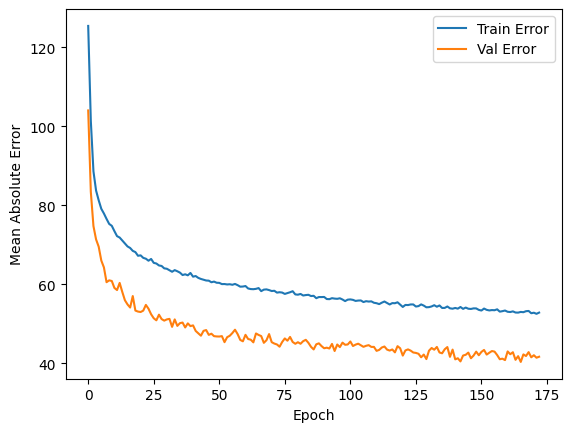

In [21]:
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.plot(hist['index'], hist['mae'], label='Train Error')
    plt.plot(hist['index'], hist['val_mae'], label = 'Val Error')
    plt.legend()
    # plt.ylim([0,50])

plot_history()

## Final Model Graphs

In [121]:
# Julian's best model
julian_model = models.load_model('final_model.keras')
# learning_rate = julian_model.optimizer.learning_rate.numpy()
# print(learning_rate)

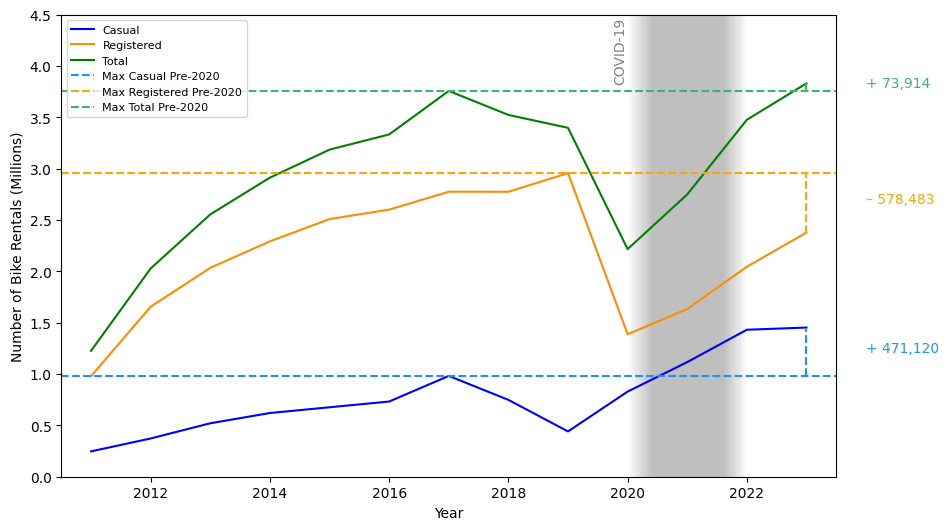

In [130]:
annual = bikes.groupby(['year']).sum().reset_index()
annual['total'] = annual['casual'] + annual['registered']
annual = annual[['year', 'casual', 'registered', 'total']]
pre2020 = annual[annual['year'] < 2020]
post2020 = annual[annual['year'] >= 2020]
# annual.head()

casual_pre2020 = pre2020['casual'].max()
registered_pre2020 = pre2020['registered'].max()
total_pre2020 = pre2020['total'].max()
casual_post2020 = post2020['casual'].max()
registered_post2020 = post2020['registered'].max()
total_post2020 = post2020['total'].max()

# Generate a smooth gradient effect
x = np.linspace(2020, 2022, 100)  # X range around the COVID highlight
ymin, ymax = 0, 4.5e6  # Y range

# Define a fading colormap from transparent to gray
cmap = LinearSegmentedColormap.from_list("fade", [
    (0, (0.5,0.5,0.5,0.)),
    (0.1, (0.5,0.5,0.5,0.25)),
    (0.2, (0.5,0.5,0.5,0.5)),
    (0.3, (0.5,0.5,0.5,0.5)),
    (0.7, (0.5,0.5,0.5,0.5)),
    (0.8, (0.5,0.5,0.5,0.5)),
    (0.9, (0.5,0.5,0.5,0.25)),
    (1, (0.5,0.5,0.5,0.)),
], N=100)

# Fill the gradient using individual patches


index = 2023
def plot_yearly_users():
    plt.figure(figsize=(10, 6))
    plt.xlabel('Year')
    plt.ylabel('Number of Bike Rentals (Millions)')
    plt.plot(annual['year'], annual['casual'], color='blue', label='Casual')
    plt.plot(annual['year'], annual['registered'], color='darkorange', label='Registered')
    plt.plot(annual['year'], annual['total'], color='green', label='Total')
    plt.axhline(y=casual_pre2020, color='dodgerblue', linestyle='--', label=f'Max Casual Pre-2020')
    plt.axhline(y=registered_pre2020, color='orange', linestyle='--', label=f'Max Registered Pre-2020')
    plt.axhline(y=total_pre2020, color='mediumseagreen', linestyle='--', label=f'Max Total Pre-2020')
    plt.vlines(x=index, ymin=casual_pre2020, ymax=casual_post2020, color='dodgerblue', linestyle='--')
    plt.vlines(x=index, ymin=registered_post2020, ymax=registered_pre2020, color='orange', linestyle='--')
    plt.vlines(x=index, ymin=total_pre2020, ymax=total_post2020, color='mediumseagreen', linestyle='--')
    plt.text(index + 1, (casual_pre2020 + casual_post2020) / 2, f'+ {casual_post2020 - casual_pre2020:,}', color='dodgerblue')
    plt.text(index + 1, (registered_pre2020 + registered_post2020) / 2, f'– {registered_pre2020 - registered_post2020:,}', color='orange')
    plt.text(index + 1, (total_pre2020 + total_post2020) / 2, f'+ {total_post2020 - total_pre2020:,}', color='mediumseagreen')
    # plt.axvspan(2020, 2022, color='gray', alpha=0.2)
    for i in range(len(x) - 1):
        color = cmap(i / len(x))
        plt.fill_between([x[i], x[i+1]], ymin, ymax, color=color, edgecolor=None)
    plt.text(2020, 3.85e6, 'COVID-19', fontsize=10, color='gray', rotation=90, ha='right')
    plt.legend(prop={'size': 8})
    plt.ylim([0, 4.5e6])
    plt.xlim([annual['year'].min() - 0.5, annual['year'].max() + 0.5])
    plt.gca().yaxis.get_offset_text().set_visible(False)

plot_yearly_users()


## Mini Holdout

In [33]:
mini = pd.read_csv('bikes_holdout_mini.csv')
mini = split_date(mini)
mini = convert_categorical(mini)
# mini.info()
mini.head()

,hr,temp_c,feels_like_c,hum,windspeed,holiday,workingday,month,day,year,fall,weather_light,weather_moderate,weather_none
0,0.0,7.3,7.3,0.6667,0.0,0,1,11,15,2023,1,0,0,1
1,1.0,6.2,6.2,0.7406,0.0,0,1,11,15,2023,1,0,0,1
2,2.0,5.2,3.2,0.8232,8.5,0,1,11,15,2023,1,0,0,1
3,3.0,5.7,3.6,0.7573,9.4,0,1,11,15,2023,1,1,0,0
4,4.0,5.2,2.9,0.7918,10.1,0,1,11,15,2023,1,1,0,0


In [34]:
mini = mini.reindex(columns = X.columns, fill_value=0)
mini_X = scaler.transform(mini)

In [ ]:
# # Single-output
# predictions = model.predict(mini_X)
# pred_df = pd.DataFrame(predictions, columns=['total'])
# pred_df.to_csv('team5-module4-predictions.csv', index=False)

In [ ]:
# Multi-output
predictions = best_model.predict(mini_X)
# predictions = model.predict(mini_X)
pred_df = pd.DataFrame(predictions, columns=['casual', 'registered'])
# pred_df.to_csv('predictions_dual.csv', index=False)
pred_df_merged = pd.DataFrame({'predictions': pred_df['casual'] + pred_df['registered']})
pred_df_merged.to_csv('team5-module4-predictions.csv', index=False)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
